In [8]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('./data/dailySentiment.csv')
df.head()

,Unnamed: 0,Day,Price,Sentiment
0,4507,20150105,3.22,-0.534077
1,4508,20150106,2.98,-0.337025
2,4509,20150107,3.08,-0.065357
3,4510,20150108,2.92,-0.326590
4,4511,20150109,2.96,-0.374404


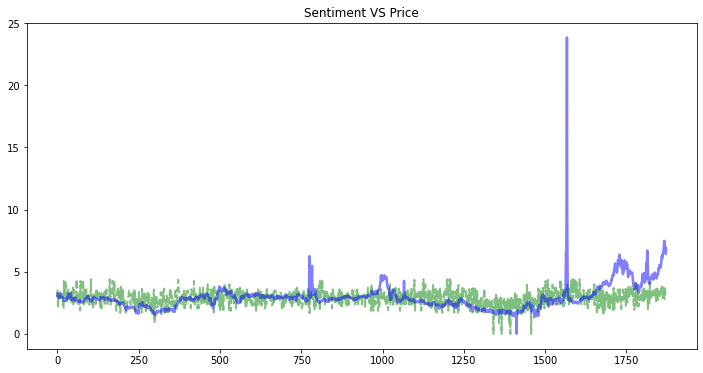

In [11]:
avg = sum(list(df.Price))/len(list(df.Price))
sen = list(df.Sentiment)
price = list(df.Price)
for i in range (len(sen)):
    sen[i] = -(sen[i]*avg)+2
plt.figure(figsize=(12, 6))
l1 = plt.plot(sen, lw = 2, color='green', alpha=0.5, linestyle='dashed')
l2 = plt.plot(price, lw = 2.5, color='blue', alpha=0.5)
plt.title('Sentiment VS Price')
plt.show()

In [12]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv1D(32, kernel_size=(3), input_shape=(180, 1)))
model.add(tf.keras.layers.MaxPool1D(pool_size=3, strides=(1), padding='valid'))
model.add(tf.keras.layers.LSTM(64, return_sequences=True))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(30))
model.compile(loss='mean_squared_error',optimizer=tf.keras.optimizers.Adam(), metrics=['mse', 'mae', 'mape'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 178, 32)           128       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 176, 32)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 176, 64)           24832     
_________________________________________________________________
flatten (Flatten)            (None, 11264)             0         
_________________________________________________________________
dense (Dense)                (None, 30)                337950    
Total params: 362,910
Trainable params: 362,910
Non-trainable params: 0
_________________________________________________________________
